train size:393, test size:21
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

0 0.80286217
0 0.47619048
1 51.374718
2 1.2216442
3 0.98523647
4 1.1393082
5 0.7538532
6 0.8182414
7 0.5755838
8 0.66232216
9 1.2020047
10 0.7412902
11 0.55317324
12 0.57199496
13 0.59889424
14 1.0132694
15 0.564343
16 1.7842697
17 0.56788045
18 0.5068189
***************acc = 0.47619048***************
19 0.40886682
20 0.66718787
21 0.62929404
22 0.60722446
23 0.6200466
24 0.62465507
25 0.48355454
26 0.5525759
27 0.42932826
28 0.35179546
29 0.53647166
30 0.4746647
31 0.4402216
32 0.44627625
33 0.98992336
34 0.5349641
35 0.746473
36 0.72115695
37 0.5699488
***************acc = 0.47619048***************
38 0.35489875
39 0.45149088
40 0.59574354
41 0.6444994
42 0.74774855
43 0.7712842
44 0.48554173
45 0.44145122
46 0.53852296
47 0.43801993
48 0.5223382
49 0.46962637
50 0.53

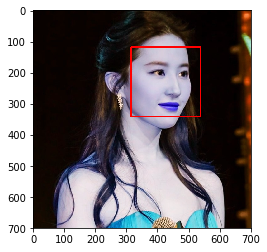

开始处理第2张预测图片：
is this Yifei Liu:? False


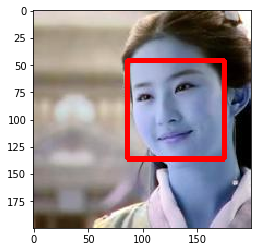

开始处理第3张预测图片：
is this Yifei Liu:? False


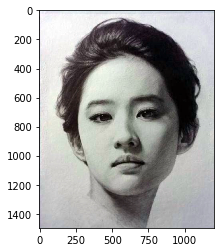

开始处理第4张预测图片：
is this Yifei Liu:? True


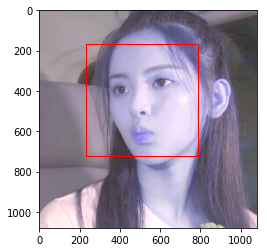

开始处理第5张预测图片：
is this Yifei Liu:? True


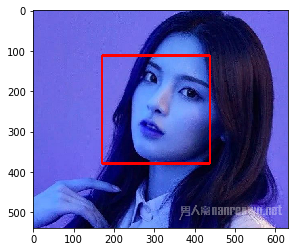

开始处理第6张预测图片：
is this Yifei Liu:? False


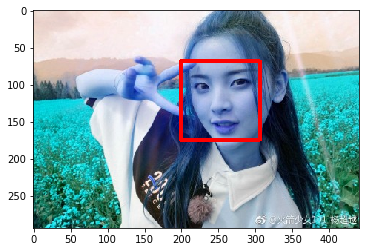

开始处理第7张预测图片：
is this Yifei Liu:? False


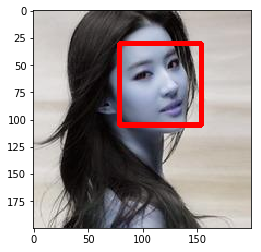

开始处理第8张预测图片：
is this Yifei Liu:? True


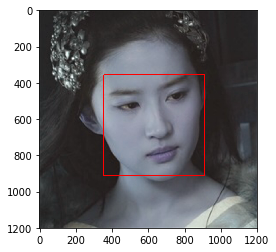

开始处理第9张预测图片：
is this Yifei Liu:? True


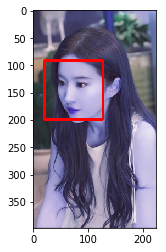

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
import random
import sys
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import dlib

my_faces_path = '/home/leipeng/facepicture/alyf'
other_faces_path = '/home/leipeng/facepicture/aotherface_200'
size = 64

imgs = []
labs = []

def getPaddingSize(img):
    h, w, _ = img.shape
    top, bottom, left, right = (0,0,0,0)
    longest = max(h, w)

    if w < longest:
        tmp = longest - w
        # //表示整除符号
        left = tmp // 2
        right = tmp - left
    elif h < longest:
        tmp = longest - h
        top = tmp // 2
        bottom = tmp - top
    else:
        pass
    return top, bottom, left, right

def readData(path , h=size, w=size):
    for filename in os.listdir(path):
        if filename.endswith('.jpg'):
            filename = path + '/' + filename

            img = cv2.imread(filename)

            top,bottom,left,right = getPaddingSize(img)
            # 将图片放大， 扩充图片边缘部分
            img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
            img = cv2.resize(img, (h, w))

            imgs.append(img)
            labs.append(path)

readData(my_faces_path)
readData(other_faces_path)
# 将图片数据与标签转换成数组
imgs = np.array(imgs)
labs = np.array([[0,1] if lab == my_faces_path else [1,0] for lab in labs])
# 随机划分测试集与训练集
train_x,test_x,train_y,test_y = train_test_split(imgs, labs, test_size=0.05, random_state=random.randint(0,100))
# 参数：图片数据的总数，图片的高、宽、通道
train_x = train_x.reshape(train_x.shape[0], size, size, 3)
test_x = test_x.reshape(test_x.shape[0], size, size, 3)
# 将数据转换成小于1的数
train_x = train_x.astype('float32')/255.0
test_x = test_x.astype('float32')/255.0

print('train size:%s, test size:%s' % (len(train_x), len(test_x)))
# 图片块，每次取100张图片
batch_size = 20
num_batch = len(train_x) // batch_size


x = tf.placeholder(tf.float32, [None, size, size, 3])
y_ = tf.placeholder(tf.float32, [None, 2])

keep_prob_5 = tf.placeholder(tf.float32)
keep_prob_75 = tf.placeholder(tf.float32)

def weightVariable(shape):
    init = tf.random_normal(shape, stddev=0.01)
    return tf.Variable(init)

def biasVariable(shape):
    init = tf.random_normal(shape)
    return tf.Variable(init)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def maxPool(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def dropout(x, keep):
    return tf.nn.dropout(x, keep)

def cnnLayer():
    # 第一层
    W1 = weightVariable([3,3,3,32]) # 卷积核大小(3,3)， 输入通道(3)， 输出通道(32)
    b1 = biasVariable([32])
    # 卷积
    conv1 = tf.nn.relu(conv2d(x, W1) + b1)
    # 池化
    pool1 = maxPool(conv1)
    # 减少过拟合，随机让某些权重不更新
    drop1 = dropout(pool1, keep_prob_5)

    # 第二层
    W2 = weightVariable([3,3,32,64])
    b2 = biasVariable([64])
    conv2 = tf.nn.relu(conv2d(drop1, W2) + b2)
    pool2 = maxPool(conv2)
    drop2 = dropout(pool2, keep_prob_5)

    # 第三层
    W3 = weightVariable([3,3,64,64])
    b3 = biasVariable([64])
    conv3 = tf.nn.relu(conv2d(drop2, W3) + b3)
    pool3 = maxPool(conv3)
    drop3 = dropout(pool3, keep_prob_5)

    # 全连接层
    Wf = weightVariable([8*16*32, 512])
    bf = biasVariable([512])
    drop3_flat = tf.reshape(drop3, [-1, 8*16*32])
    dense = tf.nn.relu(tf.matmul(drop3_flat, Wf) + bf)
    dropf = dropout(dense, keep_prob_75)

    # 输出层
    Wout = weightVariable([512,2])
    bout = weightVariable([2])
    #out = tf.matmul(dropf, Wout) + bout
    out = tf.add(tf.matmul(dropf, Wout), bout)
    return out

def cnnTrain():
    break_flag = False
    out = cnnLayer()

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y_))

    train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)
    # 比较标签是否相等，再求的所有数的平均值，tf.cast(强制转换类型)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, 1), tf.argmax(y_, 1)), tf.float32))
    # 将loss与accuracy保存以供tensorboard使用
    tf.summary.scalar('loss', cross_entropy)
    tf.summary.scalar('accuracy', accuracy)
    merged_summary_op = tf.summary.merge_all()
    # 数据保存器的初始化
    saver = tf.train.Saver()

    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())

        summary_writer = tf.summary.FileWriter('./tmp', graph=tf.get_default_graph())

        for n in range(10):
             # 每次取128(batch_size)张图片
            for i in range(num_batch):
                batch_x = train_x[i*batch_size : (i+1)*batch_size]
                batch_y = train_y[i*batch_size : (i+1)*batch_size]
                # 开始训练数据，同时训练三个变量，返回三个数据
                _,loss,summary = sess.run([train_step, cross_entropy, merged_summary_op],
                                           feed_dict={x:batch_x,y_:batch_y, keep_prob_5:0.5,keep_prob_75:0.75})
                summary_writer.add_summary(summary, n*num_batch+i)
                # 打印损失
                print(n*num_batch+i, loss)

                if (n*num_batch+i) % 100 == 0:
                    # 获取测试数据的准确率
                    acc = accuracy.eval({x:test_x, y_:test_y, keep_prob_5:1.0, keep_prob_75:1.0})
                    print(n*num_batch+i, acc)
                    # 准确率大于0.98时保存并退出
                    if acc > 0.8 and n > 2:
                        
                        saver.save(sess,'/home/leipeng/train_face_model/train_faces.cpkg')
                        print('——————————————————————存储模型完成——————————————————————')
                        break_flag = True
                        break
                        #saver.save(sess,'/train_face_model/train_faces.model')
                        #sys.exit(0)
            if break_flag == True:
                break
                
            print('***************acc = %s***************' % acc)
cnnTrain()


print('***************开始测试图片***************')


#测试自己的数据
%matplotlib inline
input_dir_test = '/home/leipeng/facepicture/faceTest'
index = 1

output = cnnLayer()  
predict = tf.argmax(output, 1)  

saver = tf.train.import_meta_graph('/home/leipeng/train_face_model/train_faces.model.meta') 
sess = tf.Session()  
saver.restore(sess, tf.train.latest_checkpoint('/home/leipeng/train_face_model/'))  

def is_my_face(image):  
    sess.run(tf.global_variables_initializer())
    res = sess.run(predict, feed_dict={x: [image/255.0], keep_prob_5:1.0, keep_prob_75: 1.0})  
    if res[0] == 1:  
        return True  
    else:  
        return False  

#使用dlib自带的frontal_face_detector作为我们的特征提取器
detector = dlib.get_frontal_face_detector()

#cam = cv2.VideoCapture(0)  
#while True:  
#    _, img = cam.read()  
#    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#    dets = detector(gray_image, 1)
#    if not len(dets):
#        print('Can`t get face.')
#        cv2.imshow('img', img)
#        key = cv2.waitKey(30) & 0xff  
#        if key == 27:
#            sys.exit(0)
for(path, dirnames, filenames) in os.walk(input_dir_test):
    for filename in filenames:
        if filename.endswith('.jpg'):
            print('开始处理第%s张预测图片：' % index)
            index += 1
            img_path = path + '/' + filename
            #从文件读取图片
            img = cv2.imread(img_path)
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            dets = detector(gray_image, 1)
            if not len(dets):
                print('不能获得图片')
                plt.imshow(img)
                plt.show()

            for i, d in enumerate(dets):
                x1 = d.top() if d.top() > 0 else 0
                y1 = d.bottom() if d.bottom() > 0 else 0
                x2 = d.left() if d.left() > 0 else 0
                y2 = d.right() if d.right() > 0 else 0
                face = img[x1:y1,x2:y2]
                # 调整图片的尺寸
                face = cv2.resize(face, (size,size))
                print('is this Yifei Liu:? %s' % is_my_face(face))

                cv2.rectangle(img, (x2,x1),(y2,y1), (255,0,0),3)
#                cv2.imshow('image',img)
                plt.imshow(img)
                plt.show()
#                key = cv2.waitKey(30) & 0xff
#                if key == 27:
#                    sys.exit(0)
#
sess.close() 
